# Laboratorio 3 - Series de Tiempo

## Conjunto de datos:
[shampoo](./shampoo.csv)

In [158]:
import pandas as pd
from numpy import mean
from numpy import median
from numpy import array
import matplotlib.pyplot as plt
from matplotlib import pyplot
import random
from math import sqrt
from sklearn.metrics import mean_squared_error
import seaborn as sns


from warnings import catch_warnings
from warnings import filterwarnings

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing


from multiprocess import cpu_count
from joblib import Parallel

from joblib import delayed

In [159]:
## Funcion utilidad
def division_entreno_prueba(datos, n_prueba):
    return datos[:-n_prueba], datos[-n_prueba:]

def medir_rmse(actual, predicho):
    return sqrt(mean_squared_error(actual, predicho))

# validación "walk-forward" para datos univariados
def validacion_al_frente(datos, n_prueba, metodo, cfg):
    predicciones = []
    # dividir el conjunto de datos
    entreno, prueba = division_entreno_prueba(datos, n_prueba)
    # grabar la historia con el conjunto de datos de entrenamiento
    historia = [x for x in entreno]
    # pasar por cada incremento de tiempo en el conjunto de prueba
    for i in range(len(prueba)):
        # ajustar el modelo a los datos y predecir los datos históricos
        if metodo == "promedio":
            yhat = prediccion_promedio(historia, cfg)
        elif metodo == "sarima":
            yhat = prediccion_sarima(historia, cfg)
        elif metodo == "exp":
            yhat = prediccion_alisamiento_exp(historia, cfg)
        # agregar el dato predicho en la lista de preducciones
        predicciones.append(yhat)
        # agregar la observación a la historia para la siguiente iteración
        historia.append(prueba[i])
    # estimar el error de las predicciones
    error = medir_rmse(prueba, predicciones)
    return [error, predicciones]

def busqueda_malla(datos, lista_cfg, n_prueba, metodo = "sarima", paralelo = True):
    resultados = None
    if paralelo:
        # ejecutar las configuraciones en paralelo
        ejecutor = Parallel(n_jobs = cpu_count(), backend = 'multiprocessing') 
        tareas = (delayed(calificar_modelo)(datos, n_prueba, metodo, cfg) for cfg in lista_cfg) 
        resultados = ejecutor(tareas)
    else:
        resultados = [calificar_modelo(datos, n_prueba, metodo, cfg) for cfg in lista_cfg]
    # eliminar resultados vacíos
    resultados = [r for r in resultados if r[1] != None]
    print(len(resultados))
    return resultados



def calificar_modelo(datos, n_prueba, metodo, cfg, debug = False):
    resultado = None
    predicciones = None
    # convertir la confiuración a una llave
    llave = str(cfg)
    if debug:
        resultado, predicciones = validacion_al_frente(datos, n_prueba, metodo, cfg)
    else:
        # una falla durante la validación del modelo sugiere una configuración inestable
        try:
        # nunca mostrar advertencias cuando se busca en malla...demasiado "ruido"
            with catch_warnings():
                filterwarnings("ignore")
                resultado, predicciones = validacion_al_frente(datos, n_prueba, metodo, cfg)
        except:
            error = None
    if resultado is not None:
        print(f' > Modelo{llave} {resultado:.3f}')
    return (llave, resultado, predicciones)

def encontrar_mejor_solucion(series, nombre, metodo = "sarima", muestra = False):
    datos = series.values
    resultados = []
    # dividir los datos
    n_prueba = int(len(datos) * 0.2) # porcenta usado para prueba
    long_max = len(datos) - n_prueba
    print(f"Tamaño Entrenamiento {long_max}")
    print(f"Tamaño Prueba {n_prueba}")

    # configuraciones de los modelos
    if metodo == "sarima":
        print(f"Encontrando la mejor solución para {metodo}")
        lista_cfg = config_sarima()
    elif metodo == "promedio":
        print(f"Encontrando la mejor solución para {metodo}")
        lista_cfg = config_simple(long_max)
    elif metodo == "exp":
        print(f"Encontrando la mejor solución para {metodo}")
        lista_cfg = config_alisamiento_exp()
        datos = datos[:,0]
    # muestrear algunos
    if muestra:
        lista_cfg_azar = random.sample(lista_cfg, k = 25)
        while len(resultados) < 5:
            lista_cfg_azar = random.sample(lista_cfg, k = 25)
            resultados += busqueda_malla(datos, lista_cfg_azar, n_prueba, metodo)
    else:
        # búsqueda en malla
        resultados = busqueda_malla(datos, lista_cfg, n_prueba, metodo)
        
    
    # ordenan las configuraciones por error, ascendente
    resultados.sort(key = lambda tup: tup[1])


    print('terminado')
    # listar las mejores 3 configuraciones
    for cfg, error, predicciones in resultados[:3]:
        print(cfg, error)

    # desplegar
    entreno, prueba = division_entreno_prueba(datos, n_prueba)
    prediccion = pd.DataFrame(list(entreno.flatten()) + resultados[0][2])
    ax = pd.DataFrame(datos).plot(label = "Original") # Datos originales
    prediccion.plot(ax = ax, alpha = .7, figsize = (14,7))
    # Esconder las líneas de malla de la gráfica
    # ax.grid(False)

    # Esconder las marcas en los ejes
    #ax.set_xticks([])
    #ax.set_yticks([])
    
    plt.savefig(f"{nombre}_{metodo}.png", transparent = True)
    plt.show()

#
#  Prediccion promedio (simple)
#

def config_simple(long_max, offsets = [1]):
    configs = []
    for i in range(1, long_max + 1):
        for t in ['mediana',"promedio"]:
            cfg = [i, t]
            configs.append(cfg)
    return configs

# prediccion de un paso por promedio
def prediccion_promedio(historia, config):
    n, tipo_promedio = config
    if tipo_promedio == 'promedio':
        return mean(historia[-n:])
    return median(historia[-n:])


#
#  Prediccion SARIMA
#

def prediccion_sarima(historia, config):
    orden, orden_estacional, tendencia = config
    # definir el modelo
    modelo = SARIMAX(historia, order = orden, seasonal_order = orden_estacional, trend = tendencia,
      enforce_stationarity = False, enforce_invertibility = False)
    # ajustar el model con los datos
    modelo_ajustado = modelo.fit(disp = False)
    # hacer la predicción de un paso
    yhat = modelo_ajustado.predict(len(historia), len(historia))
    return yhat[0]

def config_sarima(estacional = [0]):
    modelos = []
    # definir las listas de configuración
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct'] 
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = estacional
    # crear instancias de configuración
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    modelos.append(cfg)
    return modelos


#
#  Alizamiento exponencial - Holt-Winters
#

def prediccion_alisamiento_exp(historia, config):
    t, d, s, p, b, r = config
    # definir el modelo
    historia = array(historia)
    modelo = ExponentialSmoothing(historia, trend = t, damped_trend = d, seasonal = s, 
                                  seasonal_periods = p)
    # ajustar el modelo con los datos
    modelo_ajustado = modelo.fit(optimized = True, remove_bias = r)
    # predecir un paso
    yhat = modelo_ajustado.predict(len(historia), len(historia))
    return yhat[0]

def config_alisamiento_exp(estacional = [2]): 
    modelos = []
    # definir las listas de config
    t_params = ['add', 'mul', None]
    d_params = [True, False] 
    s_params = ['add', 'mul', None]
    p_params = estacional
    b_params = [True, False]
    r_params = [True, False]
    # crear instancias de configuración
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            modelos.append(cfg)
    return modelos

## Exploracion de datos

In [160]:
df = pd.read_csv('shampoo.csv')
df.head()

,Month,Sales
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3


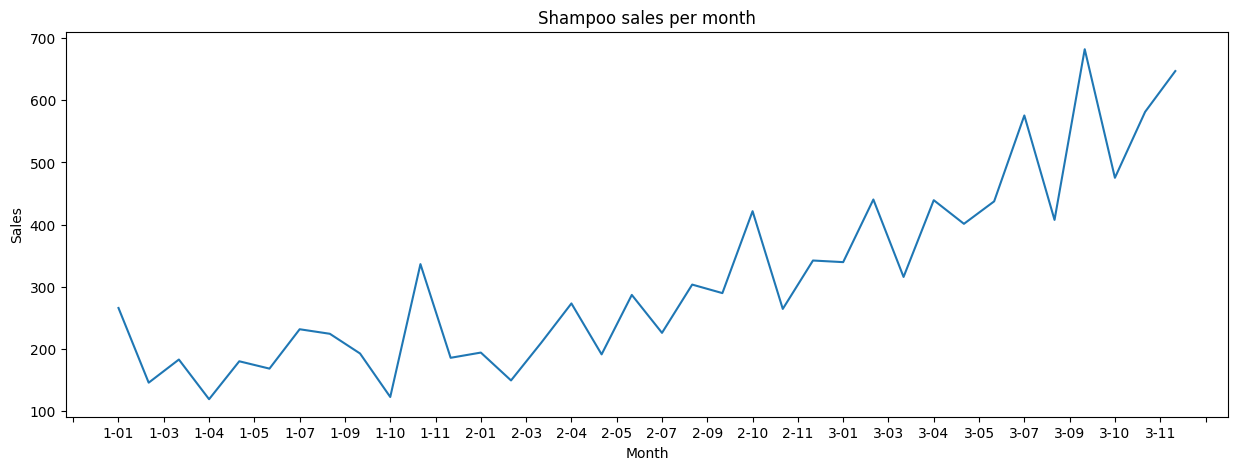

In [161]:
# Visualizacion inicial
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df['Month'], df['Sales'])
ax.set_xlabel('Month')
ax.set_ylabel('Sales')
ax.set_title('Shampoo sales per month')
ax.xaxis.set_major_locator(plt.MaxNLocator(30))
plt.show()

In [162]:
print(df.describe())

            Sales
count   36.000000
mean   312.600000
std    148.937164
min    119.300000
25%    192.450000
50%    280.150000
75%    411.100000
max    682.000000


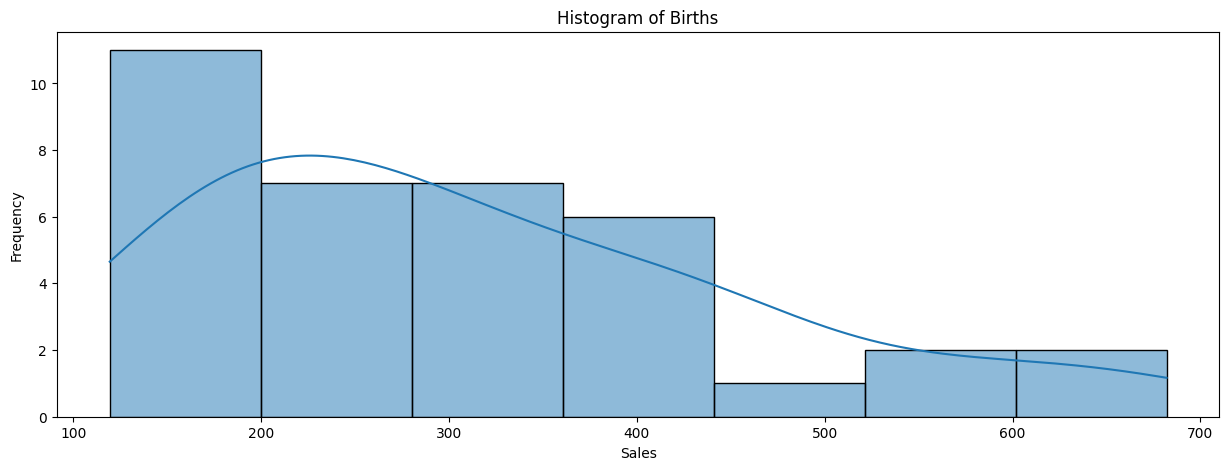

In [163]:
plt.figure(figsize=(15, 5))
sns.histplot(df['Sales'], kde=True)
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.title('Histogram of Births')
plt.show()

## Promedios

MSE: 108.23764726616282


<AxesSubplot: title={'center': 'Predicción por Promedio'}, xlabel='Month', ylabel='Sales'>

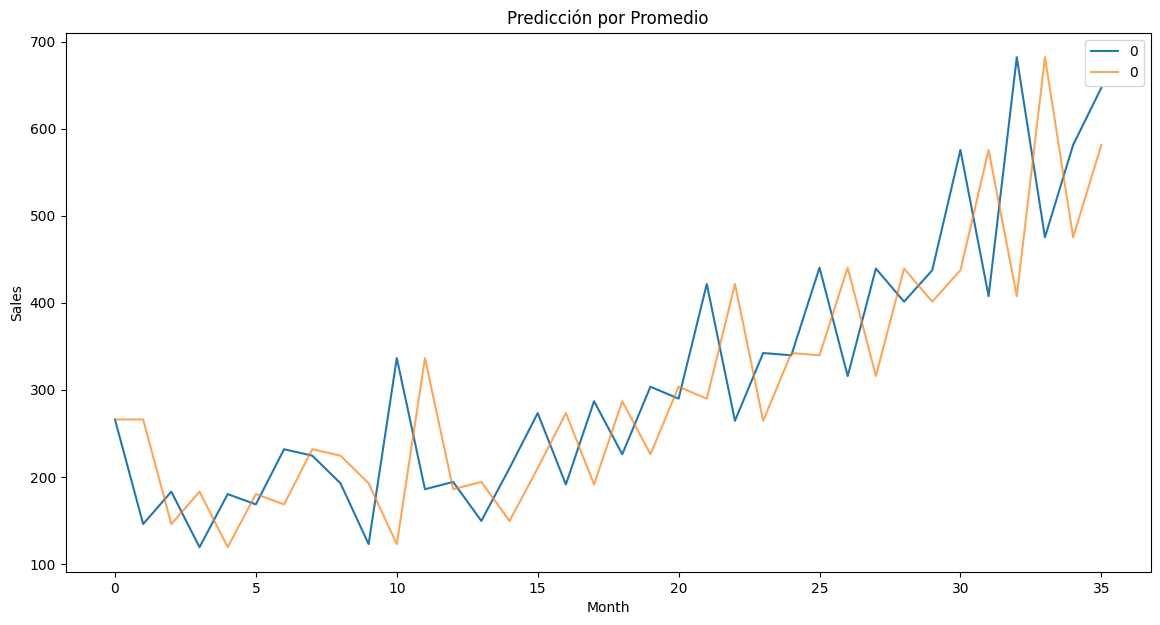

In [164]:
series = pd.read_csv('shampoo.csv', header=0, index_col=0)
datos = series.values
n_prueba = 35
long_max = len(datos) - n_prueba
cfg = config_simple(long_max)[1]
entreno = datos[:-n_prueba]
prueba = datos[-n_prueba:]
historia = [x for x in entreno]    
predicciones = []
for i in range(len(prueba)):
    yhat = prediccion_promedio(historia, cfg)
    predicciones.append(yhat)
    historia.append(prueba[i])

error = sqrt(mean_squared_error(prueba, predicciones))
print("MSE:", error)

prediccion = pd.DataFrame(list(entreno.flatten()) + predicciones)
ax = pd.DataFrame(datos).plot(label = "Original") # Datos originales
plt.title('Predicción por Promedio')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend(loc = 'upper left')

prediccion.plot(ax = ax, alpha = .7, figsize = (14,7))
# Naranja es la original
# Azul es la predicción


## SARIMA

In [165]:
datos = series.values
n_prueba = 20
long_max = len(datos) - n_prueba
lista_cfg = config_sarima()
entreno = datos[:-n_prueba]
prueba = datos[-n_prueba:]
historia = [x for x in entreno]    
predicciones = []

lista_cfg =  random.sample(lista_cfg, k = 30)
for cfg in lista_cfg:
    for i in range(len(prueba)):
            print(cfg)
            yhat = prediccion_sarima(historia, [(2, 0, 1), (0, 0, 0, 0), 't'])
            predicciones.append(yhat)
            historia.append(prueba[i])


# Keep only the non-empty predictions
# predicciones = [x for x in predicciones if x is not None]
# error = sqrt(mean_squared_error(prueba, predicciones))

[(0, 1, 1), (2, 0, 2, 0), 'n']
[(0, 1, 1), (2, 0, 2, 0), 'n']
[(0, 1, 1), (2, 0, 2, 0), 'n']
[(0, 1, 1), (2, 0, 2, 0), 'n']
[(0, 1, 1), (2, 0, 2, 0), 'n']


c:\Users\Andrès DLR\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Andrès DLR\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Andrès DLR\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[(0, 1, 1), (2, 0, 2, 0), 'n']
[(0, 1, 1), (2, 0, 2, 0), 'n']
[(0, 1, 1), (2, 0, 2, 0), 'n']
[(0, 1, 1), (2, 0, 2, 0), 'n']
[(0, 1, 1), (2, 0, 2, 0), 'n']
[(0, 1, 1), (2, 0, 2, 0), 'n']
[(0, 1, 1), (2, 0, 2, 0), 'n']
[(0, 1, 1), (2, 0, 2, 0), 'n']


c:\Users\Andrès DLR\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Andrès DLR\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[(0, 1, 1), (2, 0, 2, 0), 'n']
[(0, 1, 1), (2, 0, 2, 0), 'n']
[(0, 1, 1), (2, 0, 2, 0), 'n']
[(0, 1, 1), (2, 0, 2, 0), 'n']


c:\Users\Andrès DLR\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[(0, 1, 1), (2, 0, 2, 0), 'n']
[(0, 1, 1), (2, 0, 2, 0), 'n']
[(0, 1, 1), (2, 0, 2, 0), 'n']
[(1, 1, 2), (2, 1, 1, 0), 'c']
[(1, 1, 2), (2, 1, 1, 0), 'c']
[(1, 1, 2), (2, 1, 1, 0), 'c']
[(1, 1, 2), (2, 1, 1, 0), 'c']
[(1, 1, 2), (2, 1, 1, 0), 'c']


c:\Users\Andrès DLR\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Andrès DLR\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[(1, 1, 2), (2, 1, 1, 0), 'c']
[(1, 1, 2), (2, 1, 1, 0), 'c']
[(1, 1, 2), (2, 1, 1, 0), 'c']
[(1, 1, 2), (2, 1, 1, 0), 'c']
[(1, 1, 2), (2, 1, 1, 0), 'c']
[(1, 1, 2), (2, 1, 1, 0), 'c']
[(1, 1, 2), (2, 1, 1, 0), 'c']
[(1, 1, 2), (2, 1, 1, 0), 'c']
[(1, 1, 2), (2, 1, 1, 0), 'c']
[(1, 1, 2), (2, 1, 1, 0), 'c']
[(1, 1, 2), (2, 1, 1, 0), 'c']
[(1, 1, 2), (2, 1, 1, 0), 'c']
[(1, 1, 2), (2, 1, 1, 0), 'c']
[(1, 1, 2), (2, 1, 1, 0), 'c']
[(1, 1, 2), (2, 1, 1, 0), 'c']
[(2, 0, 1), (2, 1, 0, 0), 't']
[(2, 0, 1), (2, 1, 0, 0), 't']
[(2, 0, 1), (2, 1, 0, 0), 't']
[(2, 0, 1), (2, 1, 0, 0), 't']
[(2, 0, 1), (2, 1, 0, 0), 't']
[(2, 0, 1), (2, 1, 0, 0), 't']
[(2, 0, 1), (2, 1, 0, 0), 't']
[(2, 0, 1), (2, 1, 0, 0), 't']
[(2, 0, 1), (2, 1, 0, 0), 't']
[(2, 0, 1), (2, 1, 0, 0), 't']
[(2, 0, 1), (2, 1, 0, 0), 't']
[(2, 0, 1), (2, 1, 0, 0), 't']
[(2, 0, 1), (2, 1, 0, 0), 't']
[(2, 0, 1), (2, 1, 0, 0), 't']
[(2, 0, 1), (2, 1, 0, 0), 't']
[(2, 0, 1), (2, 1, 0, 0), 't']
[(2, 0, 1), (2, 1, 0, 0), 't']
[(2, 0, 

[205.91827576500555, 232.00727285836072, 228.7027062234963, 260.82242061461574, 261.80737328482587, 292.15414642175745, 308.9617662563901, 376.13816757873496, 358.9812536253305, 377.326180599915, 378.8197060105187, 440.6863473731335, 412.6843062120207, 453.70426650384184, 461.41969421641767, 452.9692370159307, 551.0906492677299, 453.7824074079954, 608.9847391290095, 582.0837215874345, 590.5589011492422, 883.5054505615643, 365.6899198847944, 311.54224930343855, 307.74794307434814, 335.6140228557754, 392.6587884352309, 392.96575579011784, 336.98749859821766, 369.6501640943141, 412.9537056085711, 418.88624603317413, 399.44366731956643, 447.76798072114406, 445.4723095887447, 512.622703578275, 534.534792362666, 529.4181811685495, 626.7346114577919, 550.0400352358427, 616.168209562723, 565.8139652511234, 308.7435583662715, 292.2476541596145, 292.7196274195058, 324.6176955952272, 377.65432968627806, 383.02783415058286, 332.0062248673052, 364.07389736374006, 406.02557652184646, 412.42938538722

<AxesSubplot: title={'center': 'Predicción por SARIMA'}, xlabel='Month', ylabel='Sales'>

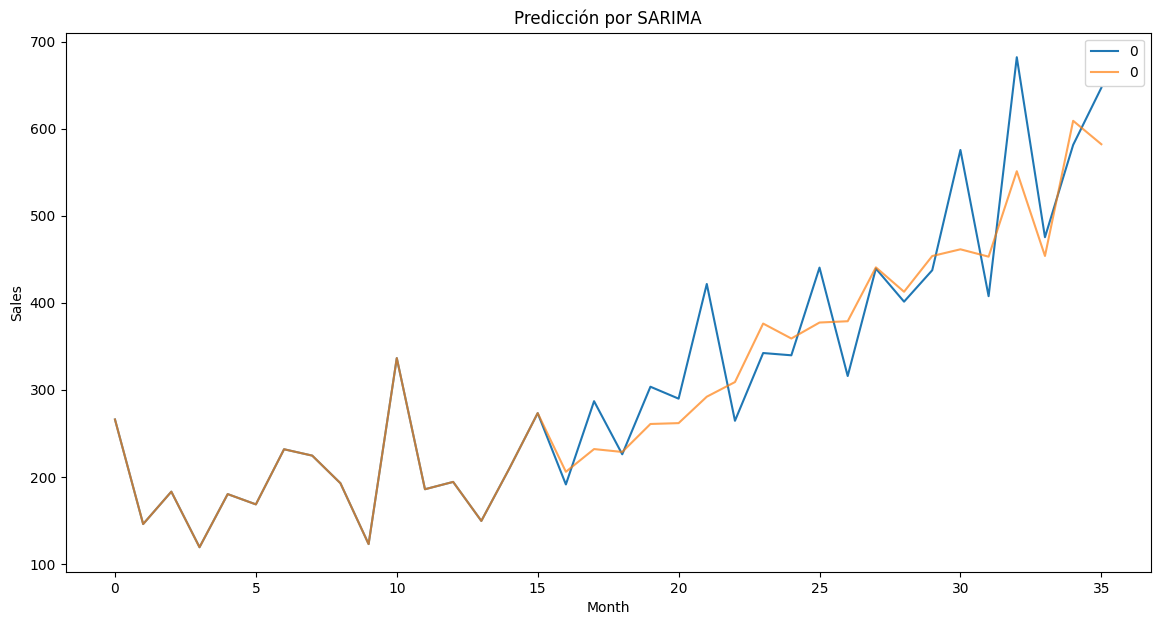

In [173]:
print(predicciones)
error = sqrt(mean_squared_error(prueba, predicciones[:20]))
print("MSE:", error)
# Visualizacion prediccion
prediccion = pd.DataFrame(list(entreno.flatten()) + predicciones[:20])
ax = pd.DataFrame(datos).plot(label = "Original") # Datos originales
plt.title('Predicción por SARIMA')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend(loc = 'upper left')

prediccion.plot(ax = ax, alpha = .7, figsize = (14,7))
# Naranja es la original
# Azul es la predicción

## Aislamiento Exponencial

In [175]:
datos = series.values
n_prueba = 20
long_max = len(datos) - n_prueba
lista_cfg = config_alisamiento_exp()
entreno = datos[:-n_prueba]
prueba = datos[-n_prueba:]
historia = [x for x in entreno]    
predicciones = []

lista_cfg =  random.sample(lista_cfg, k = 3)
for cfg in lista_cfg:
    for i in range(len(prueba)):

            yhat = prediccion_alisamiento_exp(historia, cfg)
            predicciones.append(yhat)
            historia.append(prueba[i])

print(predicciones)

# Keep only the non-empty predictions

[222.93875420427636, 217.70275865390965, 237.6668527262674, 238.7645982776249, 258.51607131841246, 271.66219117235914, 313.79647660507254, 313.59455217528256, 330.059799740533, 342.8004212569822, 417.4903264317807, 376.5972382303174, 403.9542380364333, 416.672170273242, 437.6093628138849, 529.1061431085519, 490.13036066199464, 598.997025799083, 602.214543348001, 632.1656910873819, 608.3470181658395, 469.0662705350132, 400.80166815783235, 311.22260281141104, 310.0677861876849, 302.89615696054756, 357.8248946017949, 321.5836729040095, 332.8784168670508, 338.39352428907426, 383.9492261329603, 359.038973041178, 395.07254764910266, 401.3471455368663, 420.1650028127103, 492.1740034897821, 460.09041117930553, 560.2969703514709, 528.8472861038078, 556.4955970977373, 583.6550856198872, 451.32695733612195, 361.2134896723669, 312.7899229544439, 282.84193743895736, 307.77698652724195, 331.14359776524856, 343.33491275541815, 314.650259460416, 356.98896285771946, 364.5029318132776, 363.1253731996604

MSE: 85.93937382980438


<AxesSubplot: title={'center': 'Predicción por Alisamiento Exponencial'}, xlabel='Month', ylabel='Sales'>

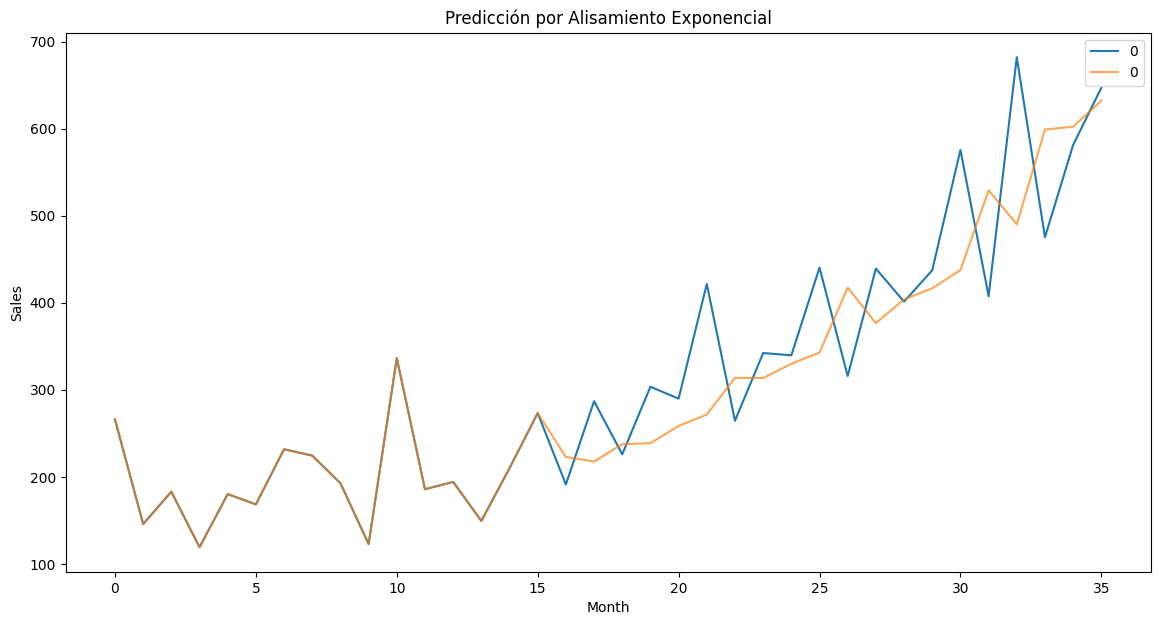

In [179]:
predicciones = [x for x in predicciones if x is not None]
error = sqrt(mean_squared_error(prueba, predicciones[0:20]))
print("MSE:", error)

# Visualizacion
prediccion = pd.DataFrame(list(entreno.flatten()) + predicciones[0:20])
ax = pd.DataFrame(datos).plot(label = "Original") # Datos originales
plt.title('Predicción por Alisamiento Exponencial')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend(loc = 'upper left')

prediccion.plot(ax = ax, alpha = .7, figsize = (14,7))
# Naranja es la original
# Azul es la predicción

## Prophet

In [192]:
from prophet import Prophet
date_format = "%d-%m"
prophet_series = pd.read_csv('shampoo.csv')
prophet_series['ds'] = pd.to_datetime(prophet_series['Month'], format=date_format)
prophet_series['y'] = prophet_series['Sales']
prophet_series = prophet_series[['ds', 'y']]
prophet_series.head()

,ds,y
0,1900-01-01,266.0
1,1900-02-01,145.9
2,1900-03-01,183.1
3,1900-04-01,119.3
4,1900-05-01,180.3


In [193]:
modelo = Prophet(mcmc_samples=500, seasonality_mode='multiplicative')
modelo_ajustado = modelo.fit(prophet_series)
futuro = modelo_ajustado.make_future_dataframe(periods=48, freq='M')
prediccion = modelo_ajustado.predict(futuro)
prediccion[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

15:59:55 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |██▊       | 00:00 Iteration:   1 / 500 [  0%]  (Warmup)
chain 1 |█████▋    | 00:00 Iteration: 200 / 500 [ 40%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                     


15:59:55 - cmdstanpy - INFO - CmdStan done processing.
15:59:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True

,ds,yhat,yhat_lower,yhat_upper
79,1904-07-31,964.309749,-79.005302,2115.280938
80,1904-08-31,1116.975775,-116.053125,2504.796324
81,1904-09-30,888.747891,-91.800795,1932.491032
82,1904-10-31,1361.103105,-182.544789,2951.177629
83,1904-11-30,1165.698425,-190.443957,2691.846388


MSE: 112.9094923894622


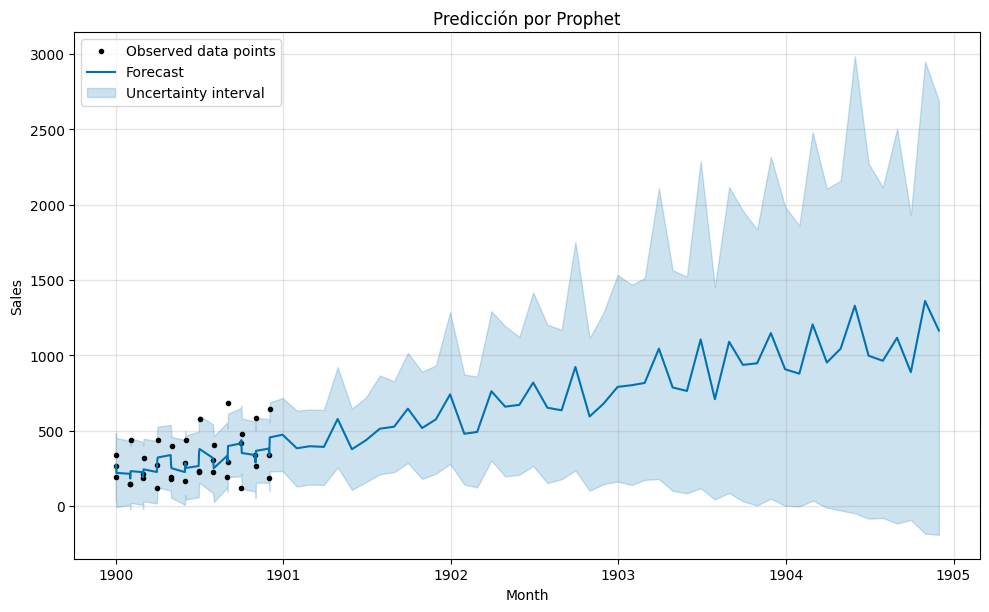

In [196]:
# MSE
error = sqrt(mean_squared_error(prophet_series['y'], prediccion['yhat'][0:36]))
print("MSE:", error)

# Visualizacion
fig = modelo_ajustado.plot(prediccion)
plt.title('Predicción por Prophet')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend(loc = 'upper left')
plt.show()


## Redes Neuronales

In [197]:
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from matplotlib import pyplot
%matplotlib inline  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Funciones

In [198]:
# split a univariate dataset into train/test sets
def division_entreno_prueba(datos, n_prueba):
    return datos[:-n_prueba], datos[-n_prueba:]

In [199]:
def series_a_supervisado(datos, n_entrada, n_salida = 1):
	df = DataFrame(datos)
	cols = []
	# secuencia de entrada (t-n, ... t-1)
	for i in range(n_entrada, 0, -1):
		cols.append(df.shift(i))
	# secuencia predicha (t, t+1, ... t+n)
	for i in range(0, n_salida):
		cols.append(df.shift(-i))
	# juntarlo todo
	agg = concat(cols, axis = 1)
	# botar columnas con valores NaN
	agg.dropna(inplace = True)
	return agg.values

In [200]:
def medir_rmse(actual, predicho):
	return sqrt(mean_squared_error(actual, predicho))

In [201]:
def ajustar_modelo(entreno, config):
	# desempacar la configuración
	n_entrada, n_nodos, n_epocas, n_tandas = config
    #[24, 500, 100, 100]
    # preparar los datos
	datos = series_a_supervisado(entreno, n_entrada)
	entreno_x, entreno_y = datos[:, :-1], datos[:, -1]
	# definir el modelo
	modelo = tf.keras.Sequential()
	modelo.add(tf.keras.layers.Dense(n_nodos, activation='relu', input_dim = n_entrada))
	modelo.add(tf.keras.layers.Dense(1))
	modelo.compile(loss='mse', optimizer='adam')
	# ajustar
	modelo.fit(entreno_x, entreno_y, epochs = n_epocas, batch_size = n_tandas, verbose = 0)
	return modelo

In [202]:
def prediccion_modelo(modelo, historia, config):
	# desempacar la configuración
	n_entrada, _, _, _ = config
	# preparar los datos
	x_entrada = array(historia[-n_entrada:]).reshape(1, n_entrada)
	# predecir
	yhat = modelo.predict(x_entrada, verbose = 0)
	return yhat[0]

In [203]:
def validacion_al_frente(datos, n_prueba, cfg):
    predicciones = []
    # dividir el conjunto de datos
    entreno, prueba = division_entreno_prueba(datos, n_prueba)
    # ajustar el modelo
    modelo = ajustar_modelo(entreno, cfg)
    # grabar la historia con el conjunto de datos de entrenamiento
    historia = [x for x in entreno]
    # pasar por cada incremento de tiempo en el conjunto de prueba
    for i in range(len(prueba)):
        # ajustar el modelo a los datos y predecir los datos históricos
        yhat = prediccion_modelo(modelo, historia, cfg)
        # agregar el dato predicho en la lista de preducciones
        predicciones.append(yhat)
        # agregar la observación a la historia para la siguiente iteración
        historia.append(prueba[i])
    # estimar el error de las predicciones
    error = medir_rmse(prueba, predicciones)
    print(f' > {error:.3f}')
    return [error, predicciones]

In [204]:
def evaluacion_iter(datos, config, n_prueba, n_repeticiones = 5):
	# ajustar y evaluar el modelo n veces
    resultados = []
    predicciones = []
    for _ in range(n_repeticiones):
        resultados_temp, predicciones_temp = validacion_al_frente(datos, n_prueba, config)
        resultados.append(resultados_temp)
        predicciones.append(predicciones_temp)
    return [resultados, predicciones]

In [205]:
def resumir_resultados(nombre, resultados):
	# imprimir un resúmen
	media_result, std_result = mean(resultados), std(resultados)
	print(f'{nombre}: {media_result:.3f} RMSE (+/- {std_result:.3f})')
	# gráficas de caja y bigotes
	pyplot.boxplot(resultados)
	pyplot.show()

In [206]:
def buscar_mejor_solucion(series, nombre, metodo = "red neuronal"):
    datos = series.values
    n_prueba = int(len(datos)*0.2) # porcentaje utilizado para prueba
    config = [24, 500, 100, 100]
    resultados, predicciones = evaluacion_iter(datos, config, n_prueba)
    resumir_resultados('mlp', resultados)
    plt.savefig(f"resultados_{nombre}_{metodo}.png")
    plt.show()
    entreno, prueba = division_entreno_prueba(datos,n_prueba)
    prediccion = pd.DataFrame(list(entreno.flatten()) + np.array(predicciones[0]).flatten().tolist())
    ax = pd.DataFrame(datos).plot(label="Original") # datos originales
    prediccion.plot(ax=ax, alpha=.7, figsize=(14,7))
    plt.savefig(f"pred_{nombre}_{metodo}.png")
    plt.show()

 > 120.575
 > 113.797
 > 111.744
 > 94.691
 > 106.908
mlp: 109.543 RMSE (+/- 8.628)


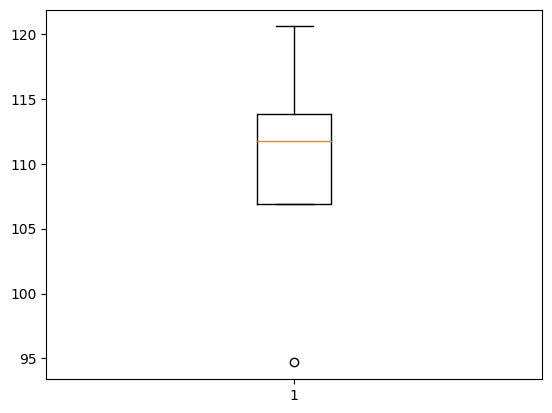

<Figure size 640x480 with 0 Axes>

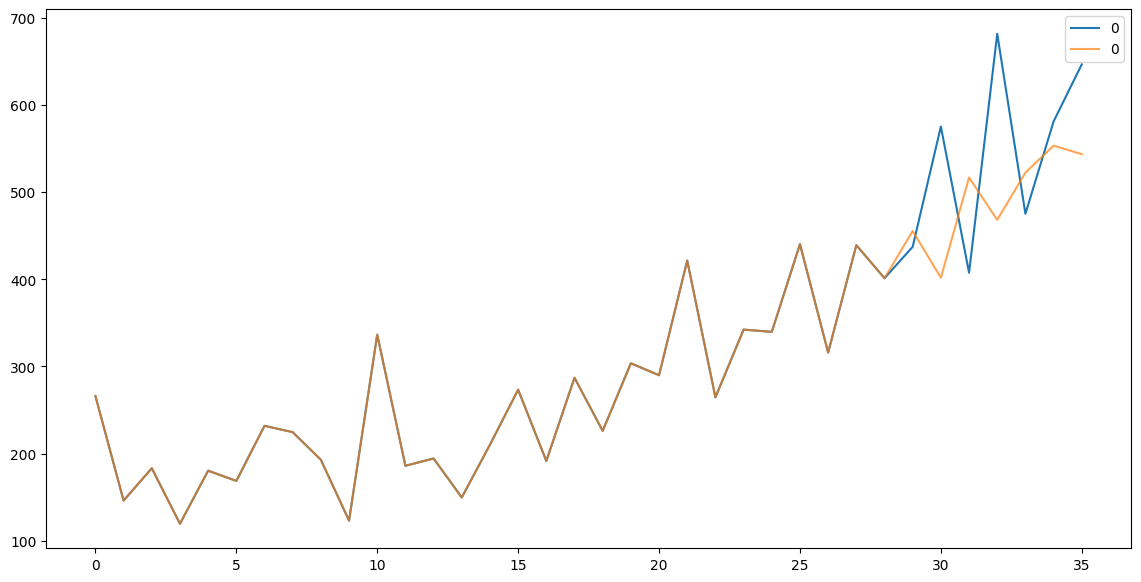

In [207]:
series_birth = pd.read_csv('shampoo.csv', header=0, index_col=0)
buscar_mejor_solucion(series_birth, "Sales")